# LightGBM with random split for early stopping

<https://www.kaggle.com/skooch/xgboost#Geo-aggregates>

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import lightgbm as lgb
import xgboost as xgb

from sklearn.metrics import f1_score
from joblib import Parallel, delayed
#from sklearn.externals.joblib import Parallel, delayed
from sklearn.base import clone
from sklearn.ensemble import VotingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.utils import class_weight

import warnings
warnings.filterwarnings("ignore")

## 데이터 설명

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print(train.shape)
print(test.shape)

(9557, 143)
(23856, 142)


In [3]:
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [4]:
test.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,ID_2f6873615,NaN,0,5,0,1,1,0,NaN,1,...,4,0,16,9,0,1,2.25,0.25,272.25,16
1,ID_1c78846d2,NaN,0,5,0,1,1,0,NaN,1,...,41,256,1681,9,0,1,2.25,0.25,272.25,1681
2,ID_e5442cf6a,NaN,0,5,0,1,1,0,NaN,1,...,41,289,1681,9,0,1,2.25,0.25,272.25,1681
3,ID_a8db26a79,NaN,0,14,0,1,1,1,1.0,0,...,59,256,3481,1,256,0,1.00,0.00,256.00,3481
4,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,...,18,121,324,1,0,1,0.25,64.00,NaN,324


__<데이터>__
- 기본 설명
    - 대회용 데이터이므로 test data label X
    - 각 행은 한 사람을 뜻함
    - 한 가구에 여러 사람 있을 수 있음. 
    - 평가할 때는 가구 내 중복을 막기 위해 가장 데이터만 사용!
    - 평가 지표: macro F1-score

- 주요 변수
    - Id: key값
    - Target(y): an ordinal variable indicating groups of income levels.
        - 1 = extreme poverty
        - 2 = moderate poverty
        - 3 = vulnerable households
        - 4 = non vulnerable households
    - idhogar: 각 가구에 대한 unique identifier. This can be used to create household-wide features, etc. All rows in a given household will have a matching value for this identifier.
    - parentesco1: 가장인지 여부
    
- 추가 변수 설명: <https://www.kaggle.com/c/costa-rican-household-poverty-prediction/data>

## 전처리

### 전처리 함수 정의

#### idhogar: 문자형 --> 수치형

In [5]:
from sklearn.preprocessing import LabelEncoder

def encode_data(df):
    df['idhogar'] = LabelEncoder().fit_transform(df['idhogar'])

#### Decision Tree의 feature importance 그리기

In [6]:
def feature_importance(forest, X_train, display_results=True):
    ranked_list = []
    zero_features = []
    
    importances = forest.feature_importances_
    
    indices = np.argsort(importances)[::-1] ## array의 각 원소에 대해 순서 indices 반환
    
    if display_results:
        print("Feature ranking:")
    
    for f in range(X_train.shape[1]): # 각 feature에 대해
        if display_results:
            print("%d. feature %d (%f)" % (f+1, indices[f], importances[indices[f]]) + '-' + X_train.columns[indices[f]])
            
        ranked_list.append(X_train.columns[indices[f]])
        
        if importances[indices[f]] == 0.0:
            zero_features.append(X_train.columns[indices[f]])
            
    return ranked_list, zero_features

#### 변수 생성

In [7]:
def do_features(df):
    
    #변수 생성1: 두 변수 나눠서 변수 생성 (비율에 관한 변수)
    feats_div = [('children_fraction', 'r4t1', 'r4t3'), 
                 ('working_man_fraction', 'r4h2', 'r4t3'),
                 ('all_man_fraction', 'r4h3', 'r4t3'),
                 ('human_density', 'tamviv', 'rooms'),
                 ('human_bed_density', 'tamviv', 'bedrooms'),
                 ('rent_per_person', 'v2a1', 'r4t3'),
                 ('rent_per_room', 'v2a1', 'rooms'),
                 ('mobile_density', 'qmobilephone', 'r4t3'),
                 ('tablet_density', 'v18q1', 'r4t3'),
                 ('mobile_adult_density', 'qmobilephone', 'r4t2'),
                 ('tablet_adult_density', 'v18q1', 'r4t2')]
    
    for f_new, f1, f2 in feats_div:
        df['fe_' + f_new] = (df[f1] / df[f2]).astype(np.float32)
    
    
    #변수 생성2: 두 변수 빼서 변수 생성
    feats_sub = [('people_not_living', 'tamhog', 'tamviv'),
                 ('people_weird_stat', 'tamhog', 'r4t3')]
    
    for f_new, f1, f2 in feats_sub:
        df['fe_' + f_new] = (df[f1] - df[f2]).astype(np.float32)
        
    
    
    # 변수 생성3: 기초 통계값 생성
    
    aggs_num = {'age': ['min', 'max', 'mean'],
                'escolari': ['min', 'max', 'mean']}
    
    aggs_cat = {'dis': ['mean']}

    for s_ in ['estadocivil', 'parentesco', 'instlevel']: 
        for f_ in [f_ for f_ in df.columns if f_.startswith(s_)]: #위의 s_로 시작하는 column에 대해
            aggs_cat[f_] = ['mean', 'count'] # aggs_cat에 추가 변수 생성

    # aggregation over household
    for name_, df_ in [('18', df.query('age >= 18'))]: #name_: '18' , df_: df
        df_agg = df_.groupby('idhogar').agg({**aggs_num, **aggs_cat}).astype(np.float32) # 두 사전을 합친 후(**), 각 변수에 대해 주어진 통계값 연산
        df_agg.columns = pd.Index(['agg' + name_ + '_' + e[0] + "_" + e[1].upper() for e in df_agg.columns.tolist()])
        df = df.join(df_agg, how='left', on='idhogar')
        del df_agg

    # 변수 삭제
    df.drop(['Id'], axis=1, inplace=True)
    
    return df

__<변수생성 1>__

|index|변수명1|설명1|변수명2|설명2|
|-|------:|:----|------|:----|
|1|r4t1|persons younger than 12 years of age|r4t3|Total persons in the household
|2|r4h2|Males 12 years of age and older|r4t3|Total persons in the household|
|3|r4h3|Total males in the household|r4t3|Total persons in the household|
|4|tamviv|number of persons living in the household|rooms|number of all rooms in the house|
|5|tamviv|number of persons living in the household|bedrooms|number of bedrooms|
|6|v2a1|Monthly rent payment|r4t3|Total persons in the household|
|7|v2a1|Monthly rent payment|rooms|number of all rooms in the house|

__<변수생성 2>__

- estadocivil: 혼인 상태
    - estadocivil1, =1 if less than 10 years old
    - estadocivil2, =1 if free or coupled uunion
    - estadocivil3, =1 if married
    - estadocivil4, =1 if divorced
    - estadocivil5, =1 if separated
    - estadocivil6, =1 if widow/er
    - estadocivil7, =1 if single
    
    
- parentesco: 가정에서의 직위
    - parentesco1, =1 if household head
    - parentesco2, =1 if spouse/partner
    - parentesco3, =1 if son/doughter
    - parentesco4, =1 if stepson/doughter
    - parentesco5, =1 if son/doughter in law
    - parentesco6, =1 if grandson/doughter
    - parentesco7, =1 if mother/father
    - parentesco8, =1 if father/mother in law
    - parentesco9, =1 if brother/sister
    - parentesco10, =1 if brother/sister in law
    - parentesco11, =1 if other family member
    - parentesco12, =1 if other non family member


- instlevel: 교육 수준
    - instlevel1, =1 no level of education
    - instlevel2, =1 incomplete primary
    - instlevel3, =1 complete primary
    - instlevel4, =1 incomplete academic secondary level
    - instlevel5, =1 complete academic secondary level
    - instlevel6, =1 incomplete technical secondary level
    - instlevel7, =1 complete technical secondary level
    - instlevel8, =1 undergraduate and higher education
    - instlevel9, =1 postgraduate higher education

__<변수생성 3>__
- idhogar: 각 가구에 대한 unique identifier.

In [8]:
## 코드 이해 참고
aggs_num = {'age': ['min', 'max', 'mean'],
            'escolari': ['min', 'max', 'mean']}
aggs_cat = {'dis': ['mean']}
train.groupby('idhogar').agg({**aggs_num, **aggs_cat}).astype(np.float32)

age                  escolari                  dis
            min   max       mean      min   max      mean mean
idhogar                                                       
001ff74ca   0.0  38.0  19.000000      0.0  16.0  8.000000  0.0
003123ec2   1.0  24.0  12.750000      0.0   7.0  3.250000  0.0
004616164  16.0  50.0  33.000000      3.0  11.0  7.000000  0.0
004983866  16.0  59.0  37.500000      7.0   8.0  7.500000  0.0
005905417   6.0  32.0  17.333334      0.0   9.0  5.666667  0.0
...         ...   ...        ...      ...   ...       ...  ...
ff9343a35  24.0  55.0  39.500000      6.0  11.0  8.000000  0.0
ff9d5ab17   0.0  32.0  19.666666      0.0  16.0  9.000000  0.0
ffae4a097  54.0  68.0  61.000000      6.0  11.0  8.500000  0.0
ffe90d46f   9.0  53.0  31.250000      2.0   5.0  3.000000  0.0
fff7d6be1  40.0  74.0  56.000000      6.0  12.0  8.500000  0.0

[2988 rows x 7 columns]

#### Onehot Encoding 변수 => Label Encoding 변수

In [9]:
# convert one hot encoded fields to label encoding
def convert_OHE2LE(df):
    tmp_df = df.copy(deep=True) #deep=True: 원본 데이터가 변해도 안변함.
    for s_ in ['pared', 'piso', 'techo', 'abastagua', 'sanitario', 'energcocinar', 'elimbasu', 
               'epared', 'etecho', 'eviv', 'estadocivil', 'parentesco', 
               'instlevel', 'lugar', 'tipovivi',
               'manual_elec']:
        if 'manual_' not in s_: # 'manual_elec' 아니면 => 각 단어로 시작하는 변수 저장
            cols_s_ = [f_ for f_ in df.columns if f_.startswith(s_)]
        elif 'elec' in s_: # 'manual_elec' 이면 => 주어진 변수 사용
            cols_s_ = ['public', 'planpri', 'noelec', 'coopele']
        sum_ohe = tmp_df[cols_s_].sum(axis=1).unique() # 긱 행에 대해 합 값의 종류
        
        #deal with those OHE, where there is a sum over columns == 0
        if 0 in sum_ohe:
            print('The OHE in {} is incomplete. A new column will be added before label encoding'
                  .format(s_))
            # dummy colmn name to be added
            col_dummy = s_+'_dummy'
            # add the column to the dataframe
            tmp_df[col_dummy] = (tmp_df[cols_s_].sum(axis=1) == 0).astype(np.int8)
            # add the name to the list of columns to be label-encoded
            cols_s_.append(col_dummy)
            # proof-check, that now the category is complete
            sum_ohe = tmp_df[cols_s_].sum(axis=1).unique()
            if 0 in sum_ohe:
                 print("The category completion did not work")
        tmp_cat = tmp_df[cols_s_].idxmax(axis=1)
        tmp_df[s_ + '_LE'] = LabelEncoder().fit_transform(tmp_cat).astype(np.int16)
        if 'parentesco1' in cols_s_:
            cols_s_.remove('parentesco1')
        tmp_df.drop(cols_s_, axis=1, inplace=True)
    return tmp_df

### 전처리 시행

####  "idhogar: 문자형 --> 수치형" & "변수 생성"

In [10]:
def process_df(df_):
    # encode the idhogar
    encode_data(df_)
    
    # create aggregate features
    return do_features(df_)

train = process_df(train)
test = process_df(test)

#### 값 변경하기

In [11]:
train['dependency'] = np.sqrt(train['SQBdependency'])
test['dependency'] = np.sqrt(test['SQBdependency'])

In [12]:
train.loc[train['edjefa'] == "no", "edjefa"] = 0
train.loc[train['edjefe'] == "no", "edjefe"] = 0
test.loc[test['edjefa'] == "no", "edjefa"] = 0
test.loc[test['edjefe'] == "no", "edjefe"] = 0

In [13]:
train.loc[(train['edjefa'] == "yes") & (train['parentesco1'] == 1), "edjefa"] = train.loc[(train['edjefa'] == "yes") & (train['parentesco1'] == 1), "escolari"]
train.loc[(train['edjefe'] == "yes") & (train['parentesco1'] == 1), "edjefe"] = train.loc[(train['edjefe'] == "yes") & (train['parentesco1'] == 1), "escolari"]

test.loc[(test['edjefa'] == "yes") & (test['parentesco1'] == 1), "edjefa"] = test.loc[(test['edjefa'] == "yes") & (test['parentesco1'] == 1), "escolari"]
test.loc[(test['edjefe'] == "yes") & (test['parentesco1'] == 1), "edjefe"] = test.loc[(test['edjefe'] == "yes") & (test['parentesco1'] == 1), "escolari"]

In [14]:
train.loc[train['edjefa'] == "yes", "edjefa"] = 4
train.loc[train['edjefe'] == "yes", "edjefe"] = 4

test.loc[test['edjefa'] == "yes", "edjefa"] = 4
test.loc[test['edjefe'] == "yes", "edjefe"] = 4

#### Type 변환

In [15]:
train['edjefe'] = train['edjefe'].astype("int")
train['edjefa'] = train['edjefa'].astype("int")
test['edjefe'] = test['edjefe'].astype("int")
test['edjefa'] = test['edjefa'].astype("int")

#### edjef 변수 생성

In [16]:
train['edjef'] = np.max(train[['edjefa','edjefe']], axis=1)
test['edjef'] = np.max(test[['edjefa','edjefe']], axis=1)

#### 결측값 채우기

In [17]:
train['v2a1']=train['v2a1'].fillna(0)
test['v2a1']=test['v2a1'].fillna(0)

test['v18q1']=test['v18q1'].fillna(0)
train['v18q1']=train['v18q1'].fillna(0)

train['rez_esc']=train['rez_esc'].fillna(0)
test['rez_esc']=test['rez_esc'].fillna(0)

In [18]:
train.loc[train.meaneduc.isnull(), "meaneduc"] = 0
train.loc[train.SQBmeaned.isnull(), "SQBmeaned"] = 0

test.loc[test.meaneduc.isnull(), "meaneduc"] = 0
test.loc[test.SQBmeaned.isnull(), "SQBmeaned"] = 0

#### 데이터 오류 해결

In [19]:
train.loc[(train.v14a ==  1) & (train.sanitario1 ==  1) & (train.abastaguano == 0), "v14a"] = 0
train.loc[(train.v14a ==  1) & (train.sanitario1 ==  1) & (train.abastaguano == 0), "sanitario1"] = 0

test.loc[(test.v14a ==  1) & (test.sanitario1 ==  1) & (test.abastaguano == 0), "v14a"] = 0
test.loc[(test.v14a ==  1) & (test.sanitario1 ==  1) & (test.abastaguano == 0), "sanitario1"] = 0

#### "Onehot Encoding 변수 => Label Encoding 변수"

##### train과 test에 정의한 함수 적용하는 함수 생성

In [20]:
def train_test_apply_func(train_, test_, func_):
    test_['Target'] = 0
    xx = pd.concat([train_, test_])

    xx_func = func_(xx)
    train_ = xx_func.iloc[:train_.shape[0], :]
    test_  = xx_func.iloc[train_.shape[0]:, :].drop('Target', axis=1)

    del xx, xx_func
    return train_, test_

In [21]:
train, test = train_test_apply_func(train, test, convert_OHE2LE)

The OHE in techo is incomplete. A new column will be added before label encoding
The OHE in instlevel is incomplete. A new column will be added before label encoding
The OHE in manual_elec is incomplete. A new column will be added before label encoding


#### 거주 지역의 변수 통계량 붙이기

- lugar_LE: 사는 지역을 LabelEncoding한 것

In [22]:
cols_2_ohe = ['eviv_LE', 'etecho_LE', 'epared_LE', 'elimbasu_LE', 
              'energcocinar_LE', 'sanitario_LE', 'manual_elec_LE',
              'pared_LE']

cols_nums = ['age', 'meaneduc', 'dependency', 
             'hogar_nin', 'hogar_adul', 'hogar_mayor', 'hogar_total',
             'bedrooms', 'overcrowding']

def convert_geo2aggs(df_):
    tmp_df = pd.concat([df_[(['lugar_LE', 'idhogar']+cols_nums)],
                        pd.get_dummies(df_[cols_2_ohe], columns=cols_2_ohe)], # one_hot
                        axis=1)

    geo_agg = tmp_df.groupby(['lugar_LE','idhogar']).mean().groupby('lugar_LE').mean().astype(np.float32)
    geo_agg.columns = pd.Index(['geo_' + e for e in geo_agg.columns.tolist()])
    
    del tmp_df
    return df_.join(geo_agg, how='left', on='lugar_LE')

# add some aggregates by geography
train, test = train_test_apply_func(train, test, convert_geo2aggs)

In [23]:
## 코드 이해 참고
tmp_df = pd.concat([train[(['lugar_LE', 'idhogar']+cols_nums)],
                    pd.get_dummies(train[cols_2_ohe], 
                                   columns=cols_2_ohe)],axis=1)
geo_agg = tmp_df.groupby(['lugar_LE','idhogar']).mean().groupby('lugar_LE').mean().astype(np.float32)
geo_agg

,age,meaneduc,dependency,hogar_nin,hogar_adul,hogar_mayor,hogar_total,bedrooms,overcrowding,eviv_LE_0,...,manual_elec_LE_3,manual_elec_LE_4,pared_LE_0,pared_LE_1,pared_LE_2,pared_LE_3,pared_LE_4,pared_LE_5,pared_LE_6,pared_LE_7
lugar_LE,,,,,,,,,,,,,,,,,,,,,
0,40.075924,9.774446,1.409079,0.889267,2.308347,0.354344,3.197615,2.674617,1.321200,0.070982,...,0.001136,0.951732,0.677456,0.009654,0.001704,0.094832,0.001704,0.157297,0.011357,0.045997
1,38.531052,9.387654,1.021543,0.955556,2.333333,0.307407,3.288889,2.474074,1.445062,0.133333,...,0.000000,0.570370,0.618519,0.003704,0.000000,0.088889,0.003704,0.181481,0.011111,0.092593
2,36.865387,8.514721,1.174619,1.040609,2.010152,0.238579,3.050761,2.213198,1.543909,0.131980,...,0.000000,0.944162,0.548223,0.020305,0.000000,0.111675,0.000000,0.182741,0.025381,0.111675
3,37.081055,8.071382,1.392762,1.131474,2.099602,0.282869,3.231076,2.565737,1.394688,0.123506,...,0.000000,1.000000,0.366534,0.007968,0.000000,0.139442,0.000000,0.306773,0.000000,0.179283
4,35.529430,7.544099,1.185147,1.151625,2.101083,0.227437,3.252707,2.407942,1.475933,0.148014,...,0.000000,0.996390,0.483755,0.003610,0.003610,0.169675,0.000000,0.249097,0.007220,0.083032
5,36.644196,7.555388,1.361484,1.189655,2.181035,0.254310,3.370690,2.517241,1.474282,0.129310,...,0.000000,0.448276,0.465517,0.000000,0.004310,0.198276,0.000000,0.176724,0.000000,0.155172


#### num_over_18 변수 생성

- num_over_18: 가구 당 18세 이상의 인원수

In [24]:
train['num_over_18'] = 0
train['num_over_18'] = train[train.age >= 18].groupby('idhogar').transform("count")
train['num_over_18'] = train.groupby("idhogar")["num_over_18"].transform("max") # age <18 에 대해서도 채워주기 위해
train['num_over_18'] = train['num_over_18'].fillna(0) # 결측값 0으로 채우기

test['num_over_18'] = 0
test['num_over_18'] = test[test.age >= 18].groupby('idhogar').transform("count")
test['num_over_18'] = test.groupby("idhogar")["num_over_18"].transform("max")
test['num_over_18'] = test['num_over_18'].fillna(0)

#### 변수 생성 - 비율

In [25]:
def extract_features(df):
    df['bedrooms_to_rooms'] = df['bedrooms']/df['rooms']
    df['rent_to_rooms'] = df['v2a1']/df['rooms']
    df['tamhog_to_rooms'] = df['tamhog']/df['rooms'] # tamhog - size of the household
    df['r4t3_to_tamhog'] = df['r4t3']/df['tamhog'] # r4t3 - Total persons in the household
    df['r4t3_to_rooms'] = df['r4t3']/df['rooms'] # r4t3 - Total persons in the household
    df['v2a1_to_r4t3'] = df['v2a1']/df['r4t3'] # rent to people in household
    df['v2a1_to_r4t3'] = df['v2a1']/(df['r4t3'] - df['r4t1']) # rent to people under age 12
    df['hhsize_to_rooms'] = df['hhsize']/df['rooms'] # rooms per person
    df['rent_to_hhsize'] = df['v2a1']/df['hhsize'] # rent to household size
    df['rent_to_over_18'] = df['v2a1']/df['num_over_18']
    # some households have no one over 18, use the total rent for those
    df.loc[df.num_over_18 == 0, "rent_to_over_18"] = df[df.num_over_18 == 0].v2a1
    
extract_features(train)    
extract_features(test)   

#### 중복된 column 삭제하기

In [26]:
# drop duplicated columns
needless_cols = ['r4t3', 'tamhog', 'tamviv', 'hhsize', 'v18q', 'v14a', 'agesq',
                 'mobilephone', 'female', ]

instlevel_cols = [s for s in train.columns.tolist() if 'instlevel' in s]

needless_cols.extend(instlevel_cols)

train = train.drop(needless_cols, axis=1)
test = test.drop(needless_cols, axis=1)

#### train_test_split

- kaggle에서는 대회용 test 데이터를 제공하지만, y label이 없기 때문에 모델 평가를 위해 kaggle에서 제공한 train 데이터로 다시 train_test_split

- 같은 가구면 대체로 y(소득분위) 같음 => 가구별로 data 나눔


In [27]:
def split_data(train, y, sample_weight=None, households=None, test_percentage=0.20, seed=None):
    # uncomment for extra randomness
#     np.random.seed(seed=seed)
    
    train2 = train.copy()
    
    # pick some random households to use for the test data
    cv_hhs = np.random.choice(households, size=int(len(households) * test_percentage), replace=False)
    
    # select households which are in the random selection
    cv_idx = np.isin(households, cv_hhs)
    X_test = train2[cv_idx]
    y_test = y[cv_idx]

    X_train = train2[~cv_idx]
    y_train = y[~cv_idx]
    
    if sample_weight is not None:
        y_train_weights = sample_weight[~cv_idx]
        return X_train, y_train, X_test, y_test, y_train_weights
    
    return X_train, y_train, X_test, y_test

In [28]:
X = train.query('parentesco1==1') #parentesco1==1: the head of the household.
# X = train.copy()

# pull out and drop the target variable
y = X['Target'] - 1 # 1~4 => 0~3
X = X.drop(['Target'], axis=1)

np.random.seed(seed=2021)

train2 = X.copy()

train_hhs = train2.idhogar #idhogar: 가구 unique id

households = train2.idhogar.unique() # 가구별로
cv_hhs = np.random.choice(households, size=int(len(households) * 0.15), replace=False)
print(cv_hhs)

cv_idx = np.isin(train2.idhogar, cv_hhs) # 15%로 랜덤하게 뽑은 가구명의 index

# 1. kaggle에서 train으로 준 데이터를 train/test로 나누기
X_test = train2[cv_idx]
y_test = y[cv_idx]

X_train = train2[~cv_idx]
y_train = y[~cv_idx]

'''
# 2. kaggle에서 train으로 준 데이터를 모두 train에 사용
X_train = train2
y_train = y
'''

train_households = X_train.idhogar

[1304 2506 2569  221  573 2103 2455   66 2935 2348  181    0 1406 1630
 2735  771    2 1924 1084  852 1384 1514  461 2310  910 1649 1823 1911
 1511 1738 1001 2874 2331 1009  339  692 1429 1549   21  892  277 2713
 1079 1669 1590   79 2514 1063 1513  325  239 1083 1287 2823  130 1729
   12 1236  987 1766 2832 1544 2505 2086  863 2247 1257  257  320 1716
  899 1243  121  397  700  236 2927 1903 2484 2043 1075  939 1405 2187
 1337 1358 1712 2752  649  449   62 2076 1021 2866  394 1950  146 1682
 1280 1817 1963 2428 2938  363 1981 1541 1454  165 1502 2013  628 1929
 1206 1737 1176 1752  982 2489 2173   24 1584 1183 1689  965 1327 1082
 1330 1272 1527  607 2352 2478 1042 2203  848 2759 1090 1736 1928  567
 2025 1332 1512 1234 1299 2516 2046 2249  223 1930 1089 1403 1034 1827
 1587 1910  642 1826 2779 2625 1211 2774 1748 1203 1717 2891  340  953
 1702 2937 1364 2936 2641 1127 1572 2530  373 1901 1273 2786  251 2080
 1107 1100  229 2635 2768 1333  480 1455 2919  422 2125 2140 2896  679
  271 

y의 각 class별 가중치 확인

In [29]:
y_train.value_counts()

3    1659
1     380
2     304
0     185
Name: Target, dtype: int64

In [30]:
# figure out the class weights for training with unbalanced classes
from sklearn.utils import class_weight

y_train_weights = class_weight.compute_sample_weight('balanced', y_train, indices=None)
pd.Series(y_train_weights).value_counts()

0.380952    1659
1.663158     380
2.078947     304
3.416216     185
dtype: int64

#### LGBM에서 drop할 변수 지정

In [31]:
# drop some features which aren't used by the LGBM or have very low importance
extra_drop_features = [
 'agg18_estadocivil1_MEAN',
 'agg18_estadocivil6_COUNT',
 'agg18_estadocivil7_COUNT',
 'agg18_parentesco10_COUNT',
 'agg18_parentesco11_COUNT',
 'agg18_parentesco12_COUNT',
 'agg18_parentesco1_COUNT',
 'agg18_parentesco2_COUNT',
 'agg18_parentesco3_COUNT',
 'agg18_parentesco4_COUNT',
 'agg18_parentesco5_COUNT',
 'agg18_parentesco6_COUNT',
 'agg18_parentesco7_COUNT',
 'agg18_parentesco8_COUNT',
 'agg18_parentesco9_COUNT',
 'geo_elimbasu_LE_4',
 'geo_energcocinar_LE_1',
 'geo_energcocinar_LE_2',
 'geo_epared_LE_0',
 'geo_hogar_mayor',
 'geo_manual_elec_LE_2',
 'geo_pared_LE_3',
 'geo_pared_LE_4',
 'geo_pared_LE_5',
 'geo_pared_LE_6',
 'num_over_18',
 'parentesco_LE',
 'rez_esc']

In [32]:
xgb_drop_cols = extra_drop_features + ["idhogar",  'parentesco1']

### 추가 전처리: 결측치 채우기

``` python
xgb_drop_cols = extra_drop_features + ["idhogar",  'parentesco1']
```

In [99]:
X_train_ = X_train.drop(xgb_drop_cols, axis=1)
X_train_vars_na = X_train_.columns[X_train_.isna().any()]
X_train_[X_train_vars_na].isna().sum()

fe_rent_per_person         1835
fe_rent_per_room           1835
fe_tablet_density          1971
fe_tablet_adult_density    1971
dtype: int64

In [100]:
X_train_[X_train_vars_na].describe()

,fe_rent_per_person,fe_rent_per_room,fe_tablet_density,fe_tablet_adult_density
count,693.000000,693.000000,557.000000,557.000000
mean,66474.929688,36964.542969,0.475389,0.589088
std,83462.398438,28361.601562,0.343756,0.420437
min,0.000000,0.000000,0.090909,0.100000
25%,22500.000000,17500.000000,0.250000,0.333333
50%,40000.000000,30000.000000,0.333333,0.500000
75%,79875.500000,50000.000000,0.500000,0.666667
max,1000000.000000,261497.437500,3.000000,4.000000


In [102]:
## 중앙값으로 결측치 채우기
for i in X_train_vars_na:
    X_train_[i] = X_train_[i].fillna(X_train_[i].median())

In [106]:
X_test_ = X_test.drop(xgb_drop_cols, axis=1)
X_test_vars_na = X_test_.columns[X_test_.isna().any()]
X_test_[X_test_vars_na].isna().sum()

fe_rent_per_person         321
fe_rent_per_room           321
fe_tablet_density          347
fe_tablet_adult_density    347
dtype: int64

In [107]:
## 중앙값으로 결측치 채우기
for i in X_test_vars_na:
    X_test_[i] = X_test_[i].fillna(X_test_[i].median())

# 학습

## GBM(Gradient Boosting Machine)

### 기본 모델 학습 & 예측

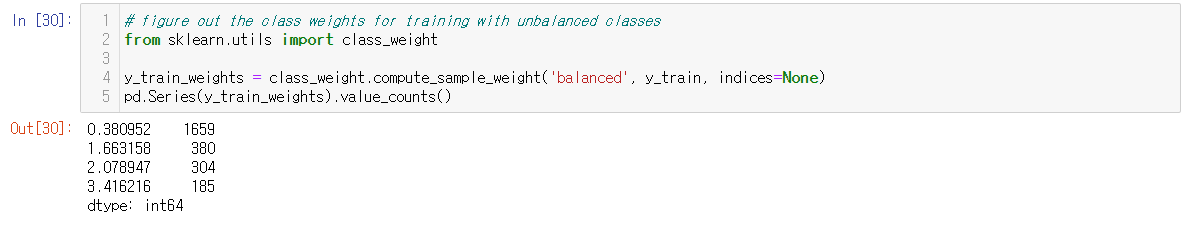
각 샘플(행)의 y가 전체 데이터에 많은 경우, weight 작게

In [157]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train_, y_train, sample_weight=y_train_weights)

gb_train_accuracy = accuracy_score(y_train, gb_clf.predict(X_train_))
gb_train_macrof1 = f1_score(y_train, gb_clf.predict(X_train_), average="macro")
#gb_train_rocauc = roc_auc_score(y_train, gb_clf.predict(X_train_), multi_class='ovo')

gb_test_accuracy = accuracy_score(y_test, gb_clf.predict(X_test_))
gb_test_macrof1 = f1_score(y_test, gb_clf.predict(X_test_), average="macro")
#gb_test_rocauc = roc_auc_score(y_test, gb_clf.predict(X_test_), multi_class='ovo')

print('GBM Train Accracy: {0:.4f}'.format(gb_train_accuracy))
print('GBM Train macro F1-score: {0:.4f}'.format(gb_train_macrof1))
#print('GBM Train ROC-AUC score: {0:.4f}'.format(gb_train_rocauc))

print('GBM Test Accracy: {0:.4f}'.format(gb_test_accuracy))
print('GBM Test macro F1-score: {0:.4f}'.format(gb_test_macrof1))
#print('GBM Test ROC-AUC score: {0:.4f}'.format(gb_test_rocauc))

GBM Train Accracy: 0.7729
GBM Train macro F1-score: 0.7167
GBM Test Accracy: 0.6292
GBM Test macro F1-score: 0.4540


### 기본 모델 Feature Importance

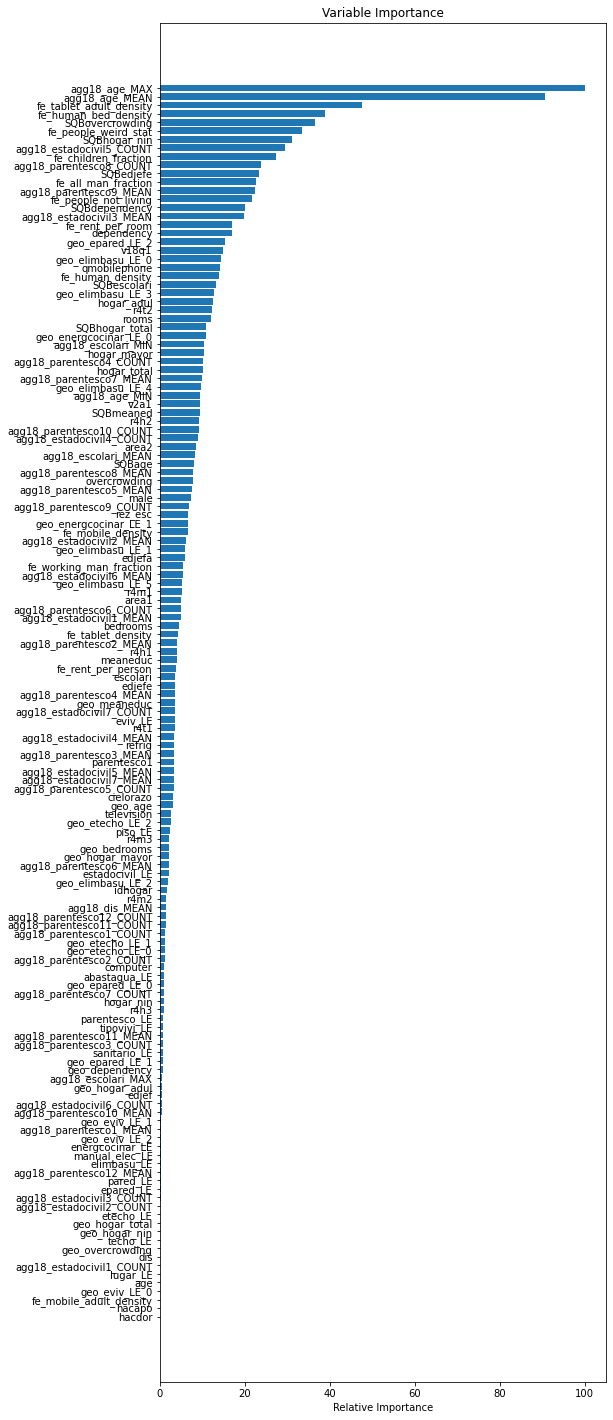

In [165]:
feature_importance = gb_clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

# plt.subplot(1, 2, 2)
plt.figure(figsize=(8, 25))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.keys()[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

### 하이퍼파라미터 튜닝

- 트리에 관한 하이퍼파라미터
    - max_depth: 트리가 오버피팅되지 않도록 깊이 제한 지정
- 부스팅(앙상블)에 관한 하이퍼파라미터
    - n_estimators: 트리 개수 지정
    - learning_rate: 낮을수록 조금씩 업데이트

In [131]:
## 기본으로 설정된 하이퍼파라미터 확인
print('max_depth:', gb_clf.max_depth) 
print('n_estimators:', gb_clf.n_estimators) 
print('learning_rate:', gb_clf.learning_rate) 

max_depth: 3
n_estimators: 100
learning_rate: 0.1


In [151]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth': [2,3,4],
    'n_estimators': [100,300,500],
    'learning_rate': [0.05, 0.1]
}

## 2-fold 교차검증으로 GridSearch 수행
grid_cv = GridSearchCV(gb_clf , param_grid=params , cv=2 ,verbose=1, scoring='f1_macro')
grid_cv.fit(X_train_ , y_train, sample_weight=y_train_weights)
print('최적 하이퍼 파라미터:', grid_cv.best_params_)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
최적 하이퍼 파라미터:
 {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300}
최고 예측 정확도: 0.2490


In [146]:
gcv_train_accuracy = accuracy_score(y_train, grid_cv.predict(X_train_))
gcv_train_macrof1 = f1_score(y_train, grid_cv.predict(X_train_), average="macro")

gcv_test_accuracy = accuracy_score(y_test, grid_cv.predict(X_test_))
gcv_test_macrof1 = f1_score(y_test, grid_cv.predict(X_test_), average="macro")

print('tuned GBM Train Accracy: {0:.4f}'.format(gcv_train_accuracy))
print('tuned GBM Train macro F1-score: {0:.4f}'.format(gcv_train_macrof1))
print('tuned GBM Test Accracy: {0:.4f}'.format(gcv_test_accuracy))
print('tuned GBM Test macro F1-score: {0:.4f}'.format(gcv_test_macrof1))

tuned GBM Train Accracy: 0.9996
tuned GBM Train macro F1-score: 0.9996
tuned GBM Test Accracy: 0.6697
tuned GBM Test macro F1-score: 0.4093


Train 정확도와 macro F1-score는 모두 더 높아짐!

default 하이퍼파라미터로 설정한 모델보다 test 정확도는 더 높아졌으나, test macro F1-score는 더 낮아짐



## LGBM

### LGBM fit

Target이 binary가 아닌 1~4까지 네 종류인 multi class인 경우라서 

eval_metric = "auc_mu"로 수정.

roc_score을 구할 때 multi_class = 'ovo' 추가

In [32]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score

lgbm_clf = LGBMClassifier(n_estimators=500)

evals = [(X_test_, y_test)]
lgbm_clf.fit(X_train_, y_train, early_stopping_rounds=100, eval_metric="auc_mu", eval_set=evals,
                verbose=True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test_),average='macro', multi_class='ovo')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

preds = lgbm_clf.predict(X_test_)
pred_proba = lgbm_clf.predict_proba(X_test_)

[1]	valid_0's auc_mu: 0.877365	valid_0's multi_logloss: 0.943779
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc_mu: 0.913367	valid_0's multi_logloss: 0.887064
[3]	valid_0's auc_mu: 0.922175	valid_0's multi_logloss: 0.841125
[4]	valid_0's auc_mu: 0.93312	valid_0's multi_logloss: 0.801482
[5]	valid_0's auc_mu: 0.936407	valid_0's multi_logloss: 0.770798
[6]	valid_0's auc_mu: 0.943563	valid_0's multi_logloss: 0.740984
[7]	valid_0's auc_mu: 0.949784	valid_0's multi_logloss: 0.712385
[8]	valid_0's auc_mu: 0.95245	valid_0's multi_logloss: 0.691064
[9]	valid_0's auc_mu: 0.956748	valid_0's multi_logloss: 0.670406
[10]	valid_0's auc_mu: 0.961168	valid_0's multi_logloss: 0.649811
[11]	valid_0's auc_mu: 0.965631	valid_0's multi_logloss: 0.630063
[12]	valid_0's auc_mu: 0.969104	valid_0's multi_logloss: 0.612647
[13]	valid_0's auc_mu: 0.971445	valid_0's multi_logloss: 0.597481
[14]	valid_0's auc_mu: 0.974173	valid_0's multi_logloss: 0.581857
[15]	valid_0's auc_mu: 0.

[140]	valid_0's auc_mu: 1	valid_0's multi_logloss: 0.0709863
[141]	valid_0's auc_mu: 1	valid_0's multi_logloss: 0.0697987
[142]	valid_0's auc_mu: 1	valid_0's multi_logloss: 0.0690532
[143]	valid_0's auc_mu: 1	valid_0's multi_logloss: 0.0681853
[144]	valid_0's auc_mu: 1	valid_0's multi_logloss: 0.0669568
[145]	valid_0's auc_mu: 1	valid_0's multi_logloss: 0.0658109
[146]	valid_0's auc_mu: 1	valid_0's multi_logloss: 0.0648481
[147]	valid_0's auc_mu: 1	valid_0's multi_logloss: 0.0637902
[148]	valid_0's auc_mu: 1	valid_0's multi_logloss: 0.0625477
[149]	valid_0's auc_mu: 1	valid_0's multi_logloss: 0.0614421
[150]	valid_0's auc_mu: 1	valid_0's multi_logloss: 0.0605553
[151]	valid_0's auc_mu: 1	valid_0's multi_logloss: 0.0596607
[152]	valid_0's auc_mu: 1	valid_0's multi_logloss: 0.0589393
[153]	valid_0's auc_mu: 1	valid_0's multi_logloss: 0.0581327
[154]	valid_0's auc_mu: 1	valid_0's multi_logloss: 0.0573675
[155]	valid_0's auc_mu: 1	valid_0's multi_logloss: 0.0565388
[156]	valid_0's auc_mu: 

87번째 조기종료, Roc Auc = 1

### multi class의 get_clf_eval

average = 'macro' 추가

multi_class='ovo' 추가

In [35]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred, average = 'macro')
    recall = recall_score(y_test , pred, average = 'macro')
    f1 = f1_score(y_test,pred, average = 'macro')
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba, multi_class='ovo')
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [36]:
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[ 29   0   0   0]
 [  0  73   0   2]
 [  0   0  50   3]
 [  0   0   0 288]]
정확도: 0.9888, 정밀도: 0.9957, 재현율: 0.9792,    F1: 0.9872, AUC:1.0000


### LGBM Feature importance

age , educ, escolari 관련 변수가 상위권을 차지함.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

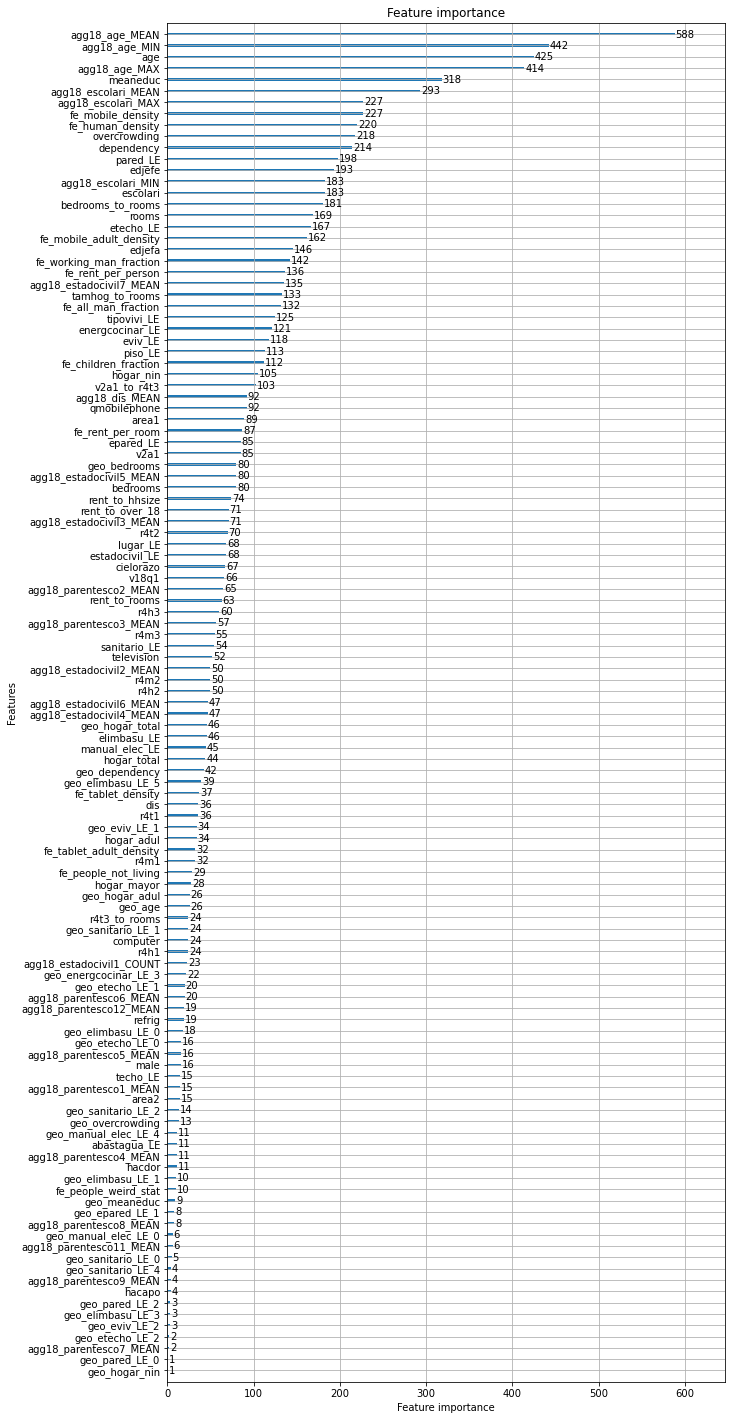

In [37]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 25))
# 사이킷런 래퍼 클래스를 입력해도 무방. 
plot_importance(lgbm_clf, ax=ax)

## 3. XGBoost

In [39]:
X_train_ = X_train.drop(xgb_drop_cols, axis=1)
X_train_vars_na = X_train_.columns[X_train_.isna().any()]
X_train_[X_train_vars_na].isna().sum()
for i in X_train_vars_na:
    X_train_[i] = X_train_[i].fillna(X_train_[i].median())

In [40]:
X_test_ = X_test.drop(xgb_drop_cols, axis=1)
X_test_vars_na = X_test_.columns[X_test_.isna().any()]
X_test_[X_test_vars_na].isna().sum()
for i in X_test_vars_na:
    X_test_[i] = X_test_[i].fillna(X_test_[i].median())

In [41]:
print(X_train.shape , X_test.shape)

(2973, 175) (445, 175)


In [42]:
print(y_train.shape , y_test.shape)

(2973,) (445,)


In [64]:
import xgboost as xgb
dtrain = xgb.DMatrix(data=X_train , label=y_train)
dtest = xgb.DMatrix(data=X_test , label=y_test)

In [65]:
xgb = XGBClassifier(n_estimators=300, learning_rate=0.1, max_depth=3)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
xgb_pred_proba = xgb.predict_proba(X_test)
print('정확도: {0:.4f}'.format(accuracy_score(y_test, xgb_pred)))

정확도: 0.8809


In [47]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average='weighted')
    recall = recall_score(y_test, pred, average='weighted')
    f1 = f1_score(y_test, pred, average='weighted')
    roc_auc = roc_auc_score(y_test, pred_proba, multi_class='ovo')
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [66]:
get_clf_eval(y_test, xgb_pred, xgb_pred_proba)

오차 행렬
[[ 23   0   0   3]
 [  1  39   1  20]
 [  0   2  23  18]
 [  1   5   2 307]]
정확도: 0.8809, 정밀도: 0.8799, 재현율: 0.8809, F1: 0.8726, AUC:0.9699


In [67]:
rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
print("RMSE: %f" % (rmse))

RMSE: 0.599625


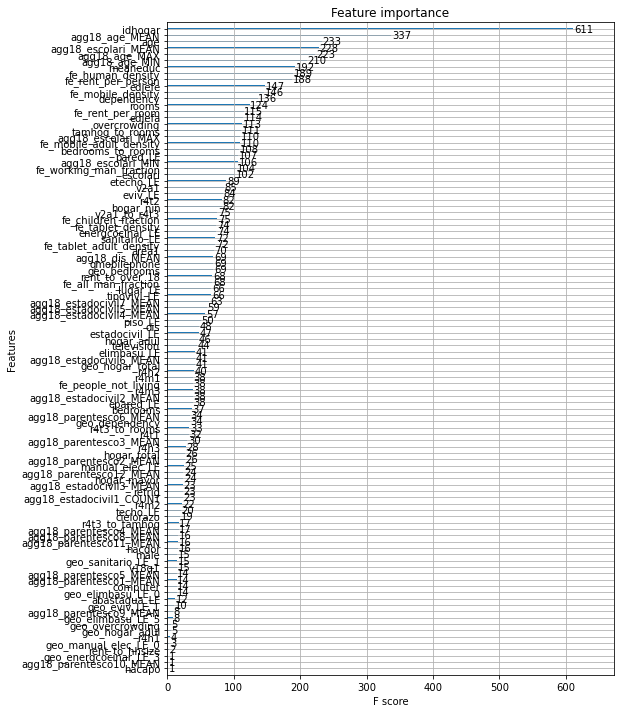

In [49]:
fix,ax = plt.subplots(figsize=(8,12))
plot_importance(xgb, ax=ax)
plt.show()

## 스태킹 모델